# Personal Diary Tracker (Sentiment Analysis)

## Goal
Input daily diary entries and track a **Mood Graph** over a week using **Sentiment Analysis** on daily text.

### Steps

1. Takes a diary entry for a date
2. Uses Hugging Face **pipeline("sentiment-analysis")**
3. Converts sentiment score into a numeric **mood value**
4. Stores results
5. Plots a **7-day Mood Graph**

## Imports

In [58]:
import os
import json
from datetime import datetime

import pandas as pd
import matplotlib.pyplot as plt

from transformers import pipeline

## Load BERT-base Sentiment Pipeline

In [59]:
sentiment_pipe = pipeline(
    "sentiment-analysis",
    model="textattack/bert-base-uncased-SST-2",
    tokenizer="textattack/bert-base-uncased-SST-2"
)


Device set to use cpu


## Store entries

In [60]:
DATA_FILE = "diary_data.json"

def load_data():
    if not os.path.exists(DATA_FILE):
        return []
    with open(DATA_FILE, "r", encoding="utf-8") as f:
        return json.load(f)

def save_data(data):
    with open(DATA_FILE, "w", encoding="utf-8") as f:
        json.dump(data, f, indent=2, ensure_ascii=False)

## Convert sentiment to a Mood Value

In [61]:
def analyze_text(text):
    result = sentiment_pipe(text)[0]
    label = result["label"]
    score = float(result["score"])

    if label.upper() == "LABEL_1":
        label = "POSITIVE"
        mood_value = score
    else:
        label = "NEGATIVE"
        mood_value = -score

    return label, score, mood_value

The BERT-base sentiment model outputs numeric labels (LABEL_0, LABEL_1).
These are mapped to human-readable sentiment classes where LABEL_1 represents positive sentiment and LABEL_0 represents negative sentiment.

## Add / Update a daily diary entry

In [62]:
def add_or_update_entry(date_str, text):
    data = load_data()
    label, score, mood_value = analyze_text(text)

    record = {
        "date": date_str,
        "entry": text,
        "sentiment_label": label,
        "sentiment_score": score,
        "mood_value": mood_value
    }

    # update if exists
    for i, r in enumerate(data):
        if r["date"] == date_str:
            data[i] = record
            save_data(sorted(data, key=lambda x: x["date"]))
            return record

    data.append(record)
    save_data(sorted(data, key=lambda x: x["date"]))
    return record

## Add today's entry (example)

In [63]:
today = datetime.now().strftime("%Y-%m-%d")

sample_entry = "Today was stressful due to assignments, but I felt relieved after finishing my work."
record = add_or_update_entry(today, sample_entry)

record

{'date': '2026-01-29',
 'entry': 'Today was stressful due to assignments, but I felt relieved after finishing my work.',
 'sentiment_label': 'POSITIVE',
 'sentiment_score': 0.9961391091346741,
 'mood_value': 0.9961391091346741}

## View Saved Data

In [64]:
data = load_data()
df = pd.DataFrame(data)
df

,date,entry,sentiment_label,sentiment_score,mood_value
0,2026-01-29,"Today was stressful due to assignments, but I ...",POSITIVE,0.996139,0.996139


## Weekly Mood Graph

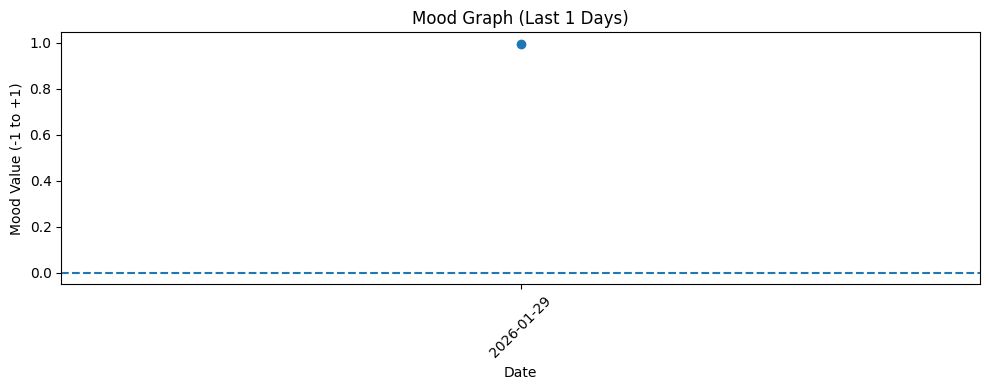

In [65]:
def plot_mood_graph(last_n=7):
    data = load_data()
    if not data:
        print("No diary entries found.")
        return

    recent = data[-last_n:]
    dates = [r["date"] for r in recent]
    moods = [r["mood_value"] for r in recent]

    plt.figure(figsize=(10, 4))
    plt.plot(dates, moods, marker="o")
    plt.axhline(0, linestyle="--")
    plt.title(f"Mood Graph (Last {len(recent)} Days)")
    plt.xlabel("Date")
    plt.ylabel("Mood Value (-1 to +1)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_mood_graph(7)

## Add 7 sample entries

In [66]:
from datetime import timedelta

base = datetime.now()

samples = [
    "I felt energetic and completed many tasks today.",
    "I was anxious about my deadlines and felt pressured.",
    "Had a normal day, nothing special happened.",
    "I enjoyed spending time with my friends and felt happy.",
    "I felt tired and bored throughout the day.",
    "I was stressed in the morning but relaxed in the evening.",
    "Today was amazing, I feel confident and motivated."
]

for i in range(7):
    d = (base - timedelta(days=6-i)).strftime("%Y-%m-%d")  # last 7 days
    add_or_update_entry(d, samples[i])

pd.DataFrame(load_data())

,date,entry,sentiment_label,sentiment_score,mood_value
0,2026-01-23,I felt energetic and completed many tasks today.,POSITIVE,0.999262,0.999262
1,2026-01-24,I was anxious about my deadlines and felt pres...,NEGATIVE,0.988080,-0.988080
2,2026-01-25,"Had a normal day, nothing special happened.",NEGATIVE,0.993280,-0.993280
3,2026-01-26,I enjoyed spending time with my friends and fe...,POSITIVE,0.999527,0.999527
4,2026-01-27,I felt tired and bored throughout the day.,NEGATIVE,0.997575,-0.997575
5,2026-01-28,I was stressed in the morning but relaxed in t...,POSITIVE,0.992338,0.992338
6,2026-01-29,"Today was amazing, I feel confident and motiva...",POSITIVE,0.999655,0.999655


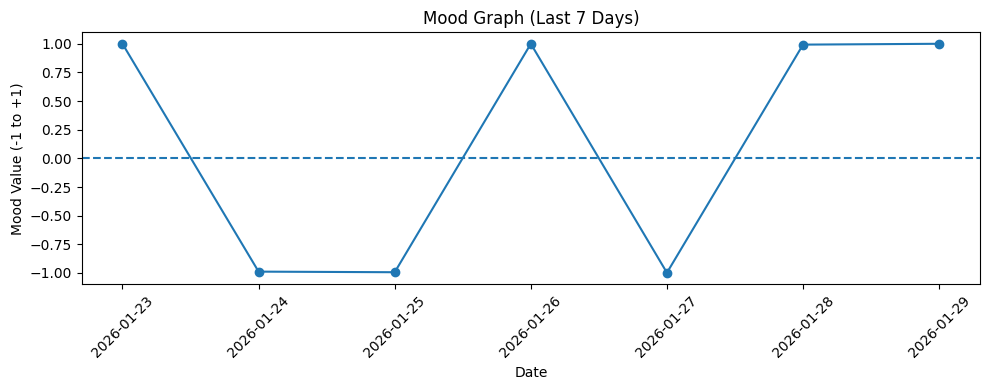

In [67]:
plot_mood_graph(7)

# Conclusion

This notebook implements a simple Personal Diary Tracker:
- Takes daily diary text
- Uses Hugging Face Sentiment Analysis pipeline
- Converts sentiment to numeric mood values
- Plots a weekly Mood Graph